In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_141c90d309b2415da230d859c23fce86 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='hzXembrCjQSB2jSQ_kICFB2_T4vastDAbVZrmuW4VofA',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_141c90d309b2415da230d859c23fce86.get_object(Bucket='week2-donotdelete-pr-t32uj9grxbaezt',Key='Churn_Modelling.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df = pd.read_csv(body)
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## ETL AND PREPROCESSING THE DATA

In [2]:
df= df.drop(['RowNumber', 'CustomerId', 'Surname'], axis =1)

In [3]:
#to calculate the null values in the data
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

###### To encode the categorical data using label encoder

In [4]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
df['Geography']=le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])

###### Selecting k best features to make the model robust and loose redundant data

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
x=df.drop('Exited',axis=1)
y=df['Exited']
#feature engineering to select importent features
bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(x,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(df.columns)
#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns,df_scores],axis=1)
feature_scores.columns = ['Column','Score']  #naming the dataframe columns
print(feature_scores.nlargest(7,'Score'))  #print 7 best features

            Column         Score
5          Balance  7.151303e+06
9  EstimatedSalary  4.835088e+04
3              Age  2.300417e+03
8   IsActiveMember  1.181994e+02
0      CreditScore  1.054035e+02
2           Gender  5.153993e+01
1        Geography  1.185325e+01


###### Standardising the data

In [6]:
from sklearn.preprocessing import StandardScaler
continuous_data=df.drop(['Geography','Gender','Exited'], axis=1)
sc=StandardScaler()
x=sc.fit_transform(continuous_data)
x=pd.DataFrame(x,columns=continuous_data.columns)
x.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276


###### Creating final data for model building

In [7]:
x = pd.concat([x,df['Geography'],df['Gender']], axis=1)
y = df['Exited']

###### Dividing into train and test data

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [9]:
print('The length of train data is {} and test data is {} for x'.format(len((x_train)),len(x_test)))
print('The length of train data is {} and test data is {} for y'.format(len((y_train)),len(y_test)))

The length of train data is 8000 and test data is 2000 for x
The length of train data is 8000 and test data is 2000 for y


## LOGISTIC REGRESSION

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)
print('accuracy on train data is:', accuracy_score(y_pred_train,y_train))
print('accuracy on test data is:', accuracy_score(y_pred_test,y_test))
print('confusion matrix is:\n',confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

accuracy on train data is: 0.80875
accuracy on test data is: 0.807
confusion matrix is:
 [[1542   53]
 [ 333   72]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1595
           1       0.58      0.18      0.27       405

   micro avg       0.81      0.81      0.81      2000
   macro avg       0.70      0.57      0.58      2000
weighted avg       0.77      0.81      0.76      2000



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## RANDOM FOREST CLASSIFIER

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [13]:
# Choose the type of classifier. 
clf = RandomForestClassifier()
# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

In [32]:
acc_scorer = make_scorer(accuracy_score)
# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(x_train, y_train)
# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
print(clf)
# Fit the best algorithm to the data. 
clf.fit(x_train, y_train)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(x_train,y_train)
y_pred_train=rf.predict(x_train)
y_pred_test=rf.predict(x_test)
print('accuracy on train data is:', accuracy_score(y_pred_train,y_train))
print('accuracy on test data is:', accuracy_score(y_pred_test,y_test))
print(classification_report(y_test,y_pred_test))

accuracy on train data is: 0.889
accuracy on test data is: 0.863
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1595
           1       0.77      0.46      0.58       405

   micro avg       0.86      0.86      0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



## GRADIENT BOOSTING CLASSIFIER

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
gb =GradientBoostingClassifier()
gb.fit(x_train, y_train)
y_pred_train=gb.predict(x_train)
y_pred_test=gb.predict(x_test)
print('accuracy on train data is:', accuracy_score(y_pred_train,y_train))
print('accuracy on test data is:', accuracy_score(y_pred_test,y_test))
print(classification_report(y_test,y_pred_test))

accuracy on train data is: 0.872
accuracy on test data is: 0.8645
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.75      0.50      0.60       405

   micro avg       0.86      0.86      0.86      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.86      0.85      2000



## ARTIFICIAL NEURAL NETWORK

In [48]:
import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout
model= Sequential()
#Add Sequential Layers
model.add(Dense(8, init='uniform' , activation = 'relu', input_dim = 10 ))
model.add(Dense(8, init='uniform' , activation = 'relu' ))
model.add(Dense(1, init='uniform' , activation = 'sigmoid'))
#Compile
model.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics = ['accuracy'] )
#fit 
model.fit(x_train, y_train, batch_size= 10, nb_epoch= 2)
#predict
y_pred = model.predict(x_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", input_dim=10, kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="uniform")`
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/2
8000/8000 [==============================] - 1006s 126ms/step - loss: 0.4833 - acc: 0.7954
Epoch 2/2
8000/8000 [==============================] - 1012s 127ms/step - loss: 0.4328 - acc: 0.7960


In [49]:
loss,accuracy=model.evaluate(x_test,y_test)
print('loss: %.2f,accuracy: %.2f%%'%(loss,accuracy*100))

2000/2000 [==============================] - 75s 37ms/step
loss: 0.42,accuracy: 79.75%


### Comparing different model accuracy

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
accuracy = []
model_names = []
models = [('LogReg', LogisticRegression()), 
          ('SVC', SVC()),
          ('DecisionTree', DecisionTreeClassifier()),
          ('RandomForest', RandomForestClassifier()),
          ('GradientBoost', GradientBoostingClassifier()),
          ('XgBoost',XGBClassifier()),
          ('AdaBoost',AdaBoostClassifier())]

In [24]:
for model_name, model in models:
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test,y_pred)
    accuracy.append(acc)
    model_names.append(model_name)
print(model_names,accuracy)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['LogReg', 'SVC', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XgBoost', 'AdaBoost'] [0.807, 0.8635, 0.7965, 0.861, 0.8645, 0.8655, 0.8615]


In [26]:
for i in range(7):
    print(model_names[i],accuracy[i])
    
print('maximum accuracy is:',max(accuracy))

LogReg 0.807
SVC 0.8635
DecisionTree 0.7965
RandomForest 0.861
GradientBoost 0.8645
XgBoost 0.8655
AdaBoost 0.8615
maximum accuracy is: 0.8655


###### Since XgBoost gave use the highest accuracy amongst all the models we apply it to generate important features

accuracy on train data is: 0.868
accuracy on test data is: 0.8655


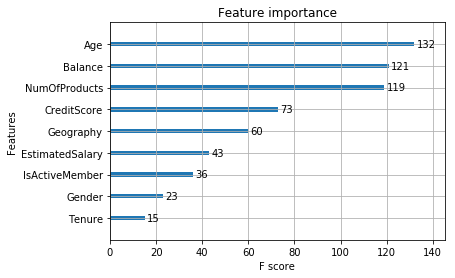

In [40]:
import seaborn as sns
from xgboost import plot_importance
xgb=XGBClassifier(booster='gbtree')
model=xgb.fit(x_train,y_train)
y_pred_train=model.predict(x_train)
y_pred_test=model.predict(x_test)
print('accuracy on train data is:', accuracy_score(y_pred_train,y_train))
print('accuracy on test data is:', accuracy_score(y_pred_test,y_test))
cm=confusion_matrix(y_pred_test,y_test)
%matplotlib inline
sns.heatmap(cm,annot=True,fmt="d")
plot_importance(model)